![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# Model-Agnostic Interpretation with SHAP for Image Analysis

In this Notebook we will demonstrate how to use the SHapley Additive exPlanations (SHAP) method and interpret its results for image classification models.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirments on your own machine, you can skip this section and start from the import section.
Otherwise you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI/blob/master/xai-model-agnostic/Tutorial_SHAP_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Now that you are visualizing the notebook in Colab, run the next cell to install the packages we will use.
There are few things you should follow in order to properly set the notebook up:

1. Warning: This notebook was not authored by Google. *Click* on 'Run anyway'.
2. When the installation commands are done, there might be "Restart runtime" button at the end of the output. Please, *click* it. 

In [1]:
# %pip install shap

By running the next cell you are going to create a folder in your Google Drive. All the files for this tutorial will be uploaded to this folder. After the first execution you might receive some warning and notification, please follow these instructions:
1. Permit this notebook to access your Google Drive files? *Click* on 'Yes', and select your account.
2. Google Drive for desktop wants to access your Google Account. *Click* on 'Allow'.

At this point, a folder has been created and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive. 

In [2]:
# Create a folder in your Google Drive
# from google.colab import drive                                                                          
# drive.mount('/content/drive')

In [3]:
# Don't run this cell if you already cloned the repo 
# !git clone https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git

In [4]:
# %cd XAI-Tutorials/xai-model-agnostic

### Imports

Let's start with importing all required Python packages.

In [65]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt
import random

Now, we fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [66]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)


--------

## The MNIST dataset: Data and Model Loading

Let's use the MNIST dataset to see how SHAP can be used to explain image classification models. The MNIST dataset contains images of handwritten digits with numbers from 0 to 9. 

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_digits.png?raw=true" width="700" /></center>

<font size=1> Source:
[Link](https://towardsdatascience.com/part-5-training-the-network-to-read-handwritten-digits-c2288f1a2de3)

We define a simple 2D CNN model with kernel size of 3 and the ReLU activation function using tensorflow. Then we train the model for a small number of epochs on our training images.

*Note: this a very basic model to showcase how SHAP works for image classification.*

In [67]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

Let's define the train/test dataloader, batch size and number of epochs for training.

In [68]:
batch_size = 128
num_epochs = 5
device = torch.device('cpu')

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)



Let's instantiate the model and call the train and test functions

In [69]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Start the training and testing process
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318843
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.182407
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.415765
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.967954
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.750068

Test set: Average loss: 0.0047, Accuracy: 8814/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.662461
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.655223
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.634076
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.461727
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.500196

Test set: Average loss: 0.0026, Accuracy: 9345/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.330920
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.449710
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.390805
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.390497
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.356790

Test set: Average loss: 0.0018, Accuracy: 9513/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.408239
Train Epoch: 4 [12800/60000 (21%)]	Lo

Great, now you trained your CNN model with a high accuracy of ~96%!  

Let's define the train and test set for computing the SHAP values.

In [75]:
batch = next(iter(test_loader))
images, labels = batch

X_train = images[:100]
X_test = images[100:103]
y_train = labels[:100]
y_test = labels[100:103]

## Now, what does my model actually think is important in the data?

We prepared a small [Introduction to SHAP](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/shap.html) for you, to help you understand how this method works.

Now lets use SHAP to get some insights into the image classification model we load below. The `shap.Explainer()` function uses the shap values to explain any machine learning model. In the SHAP library, there are multiple explainers that can be used to explain which features are important in an image for classification. Some of them are:
* [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html)
* [PartitionExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.PartitionExplainer.html)
* [GradientExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.GradientExplainer.html#shap.GradientExplainer)

All of the above use specific methods to approximate SHAP values for deep learning models. In this course, we will focus on the implementation of `shap.GradientExplainer()`,  which calculates Shapley values for CNN models in a fast and model-specific way. You can read more about each explainer in the [SHAP API](https://shap.readthedocs.io/en/latest/api.html#explainers).

**GradientExplainer**

We won't go into the details here but we will rather focus on the interpretation of the results. As a reference, we summarize the main concepts and we recommend reading the SHAP documentation and the book [Interpreting Machine Learning Models With SHAP](https://leanpub.com/shap) (Molnar 2022). 
Many models, including several neural networks, are gradient-based. This means that we can compute the gradient of the loss function with respect to the model input. When we can compute the gradient with respect to the input, we can use this information to calculate SHAP values more efficiently. There’s a connection between the Gradient Estimator and a method called Integrated Gradients (Sundararajan et al. 2017). Integrated Gradients is a feature attribution method also based on gradients that outputs the integrated path of the gradient with respect to a reference point as an explanation. The difference between Integrated Gradients and SHAP values is that Integrated Gradients use a single reference point, while Shapley values utilize a background data set.

*Note: this method is a **local** method which means that it does only provide explanations for individual samples. However, the individual explanations can be used to also get **global** interpretations.*


### Step 1 - Create a baseline

We need to select a part of our data set to create a baseline, i.e. the background dataset to use for integrating our features. Here, we use our training set `x_train` as background dataset.

In [76]:
x_background = X_train

### Step 2 - Instantiate the class
We decided to focus on GradientExplainer which is implemented in the `shap.GradientExplainer()`.  
The first argument is the model (or a tuple containing the model and the layer that should be explained, which will return shap values for the input of the layer argument). The second argument is the background dataset.


In [77]:
explainer = shap.GradientExplainer(model, x_background)

### Step 3 - Compute SHAP values on a custom image

In the `shap_values()` method we pass the image(s) we want to explain as a tensor. We can set ranked_outputs=*n* we only explain the top *n* model outputs.

*Note: it can take some time to compute the SHAP values.*

In [78]:
# we explain the model's predictions on the first three samples of the test set
x_explain = X_test[:3]

shap_values = explainer.shap_values(x_explain)
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values] # unroll the axes

#### Step 4 - Plot results

For every output node in the model, we get a one explanation for each output, i.e. our model has 10 outputs, hence, we get a list of 10 explanations.

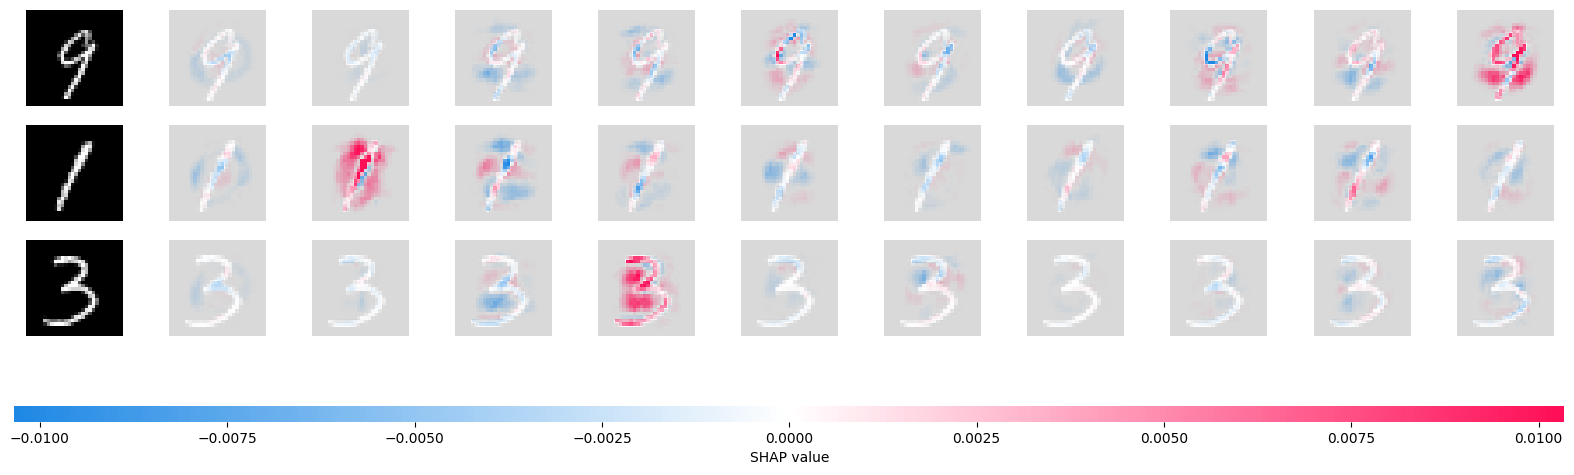

In [79]:
# here we plot the explanations for all classes for the first input (this is the feed forward input)
to_plot_x_explain = np.array(x_explain)
to_plot_x_explain = to_plot_x_explain.swapaxes(-1,1).swapaxes(1, 2)

shap.image_plot(shap_values, to_plot_x_explain)

SHAP uses colors to explain attribution:
- Red pixels increase the probability of a class being predicted
- Blue pixels decrease the probability of a class being predicted

In the images above, the input images are shown on the left column and the other columns show the SHAP value for the classes from 1 to 9, with the original image nearly transparent grayscale backings behind each of the explanations. The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset) and the current model output.